In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pws_library import get_data, cointegration_test

In [75]:
cointegration_test('PXD', 'COP', start="2010-01-01", end="2015-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
beta:3.879538017125864
alpha:-60.33228298444059
0.04036586144988592
45.43314228727948
beta:0.24135873953017173
alpha:17.192716481350963
0.048762518284399405
46.999613490318836


{'dep': 'PXD',
 'indep': 'COP',
 'beta': 3.879538017125864,
 'alpha': -60.33228298444059,
 'p-value': 0.04036586144988592,
 'halflife': 45.43314228727948}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

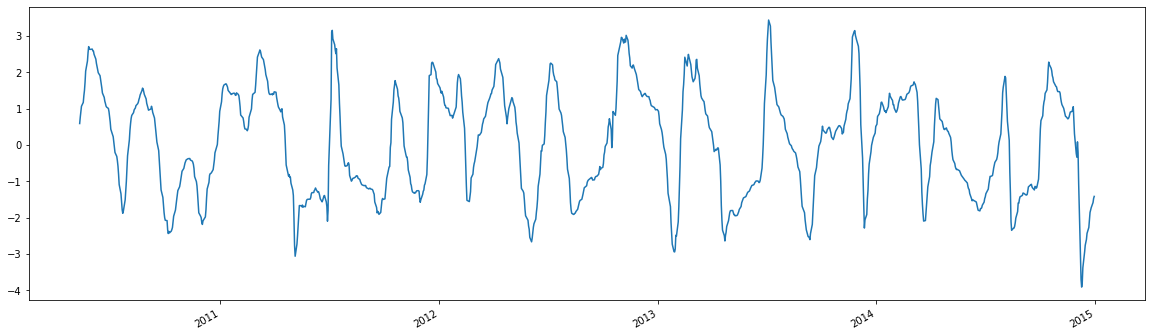

In [82]:
dependent_symbol = 'PXD'
independent_symbol = 'COP'
halflife = 45

df = get_data([independent_symbol, dependent_symbol], start="2010-01-01", end="2015-01-01")

lookback = int(np.round(halflife))
hedgeratios = np.array([])

for i in range(df.shape[0]):
    if i < lookback-1:
        hedgeratios = np.append(hedgeratios, np.NaN)
    else:
        temporary = df.iloc[i-lookback+1:i+1]

        y = np.log(temporary[dependent_symbol]).tolist()
        x = np.log(temporary[independent_symbol]).tolist()

        x = sm.add_constant(x)

        results = sm.OLS(y, x).fit()
        hedgeratios = np.append(hedgeratios, results.params[1])


df['hedgeratio'] = hedgeratios
df['spread'] = np.log(df[dependent_symbol]) - np.log(df[independent_symbol])*df['hedgeratio']
df['zscore'] = (df['spread'] - df['spread'].rolling(lookback).mean()) / df['spread'].rolling(lookback).std()
df.dropna(inplace=True)
df['zscore'].plot(figsize=(20,6))

In [77]:
#df['num_units'] = -df['zscore']
entryZscore = 2
exitZscore = 0

conditions = [(df.zscore < -entryZscore), (df.zscore >= -exitZscore)]
choices = [1, 0]
df['num_long'] = np.select(conditions, choices, default=np.NaN)

conditions1 = [(df.zscore > entryZscore), (df.zscore <= exitZscore)]
choices1 = [-1, 0]
df['num_short'] = np.select(conditions1, choices1, default=np.NaN)

df['num_short'] = df['num_short'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
df['num_long'] = df['num_long'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
df['num_units'] = df['num_long'] + df['num_short']

df[f"{dependent_symbol}_pos"] = df['num_units'] * df[dependent_symbol]
df[f"{independent_symbol}_pos"] = df['num_units'] * df[independent_symbol] * -df['hedgeratio']


<AxesSubplot:>

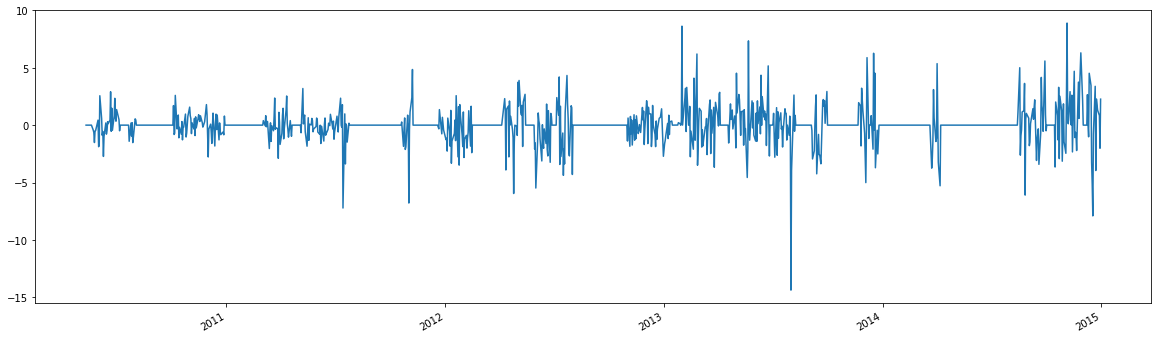

In [78]:
dep_price = df[dependent_symbol]
indep_price = df[independent_symbol]

df[f'{dependent_symbol}_pnl'] = (dep_price-dep_price.shift())/dep_price.shift()*df[f'{dependent_symbol}_pos'].shift()
df[f'{independent_symbol}_pnl'] = (indep_price-indep_price.shift())/indep_price.shift()*df[f'{independent_symbol}_pos'].shift()
df['pnl'] = df[f'{independent_symbol}_pnl'] + df[f'{dependent_symbol}_pnl']

df['pnl'].plot(figsize=(20,6))

<AxesSubplot:>

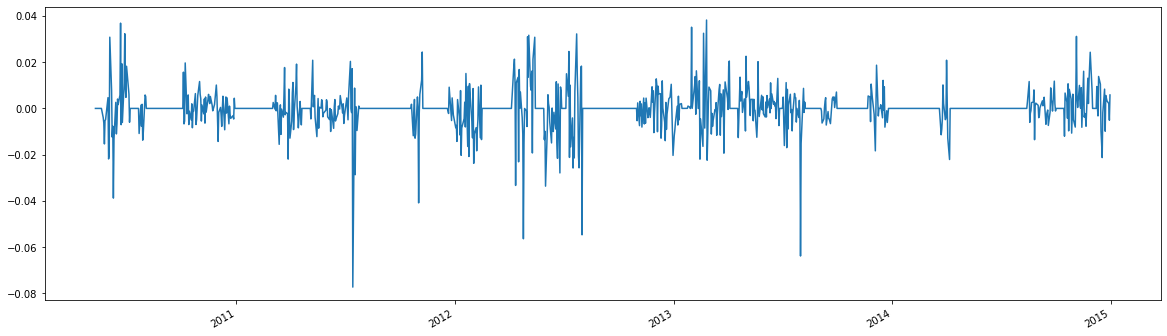

In [79]:
ret = df['pnl'] / (np.abs(df[f'{dependent_symbol}_pos'].shift()) + np.abs(df[f'{independent_symbol}_pos'].shift()))
ret = ret.fillna(0)
returns_df = pd.DataFrame(ret, columns=['ret'])
returns_df['ret'].plot(figsize=(20,6))

In [80]:
cum_ret = []
for i in range(len(ret)):
    if i == 0:
        cum_ret.append(ret.iloc[i])
    else:
        cum_ret.append((ret.iloc[i] + 1) * (cum_ret[i-1]+1) - 1)


returns_df['cum_ret'] = cum_ret

<AxesSubplot:>

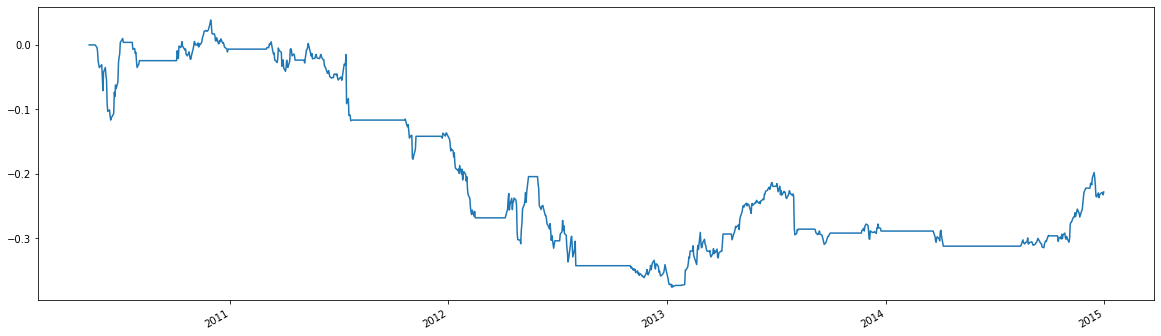

In [81]:
returns_df['cum_ret'].plot(figsize=(20,6))